# Imports

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow.compat.v1.saved_model import load, tag_constants

%matplotlib inline

# Constants

In [2]:
SAMPLE_IMAGE = 'Image_Samples/Sample3.jpeg'

ALPHABETS = {
    0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I',9:'J',
    10:'K', 11:'L', 12:'M', 13:'N', 14:'O', 15:'P', 16:'Q', 17:'R', 18:'S',
    19:'T', 20:'U', 21:'V', 22:'W', 23:'X', 24: 'Y', 25:'Z'
}

ARR_FINAL_WORDS = []
ARR_FINAL_ROWS = []

ARR_FINAL_PREDICTION_ROWS = []

# Helper Functions

In [3]:
def get_all_childs_of_parent(parent, hierarchy):
    '''
    This function will return all the child of that contour
    Parameters:
    parent : Int value
    hierarchy: contours hierarchy
    '''
    # Initialize
    hier_len = hierarchy.shape[1] #Total contours
    child_contours = {} #Empty Dict
    
    for x in range(hier_len):
        # To loop through whole hierarchy
        next_contour, pre_contour, first_child, parent_contour = hierarchy[0][x]
        
        # If desired parent found, so append it all childs
        if parent == parent_contour:
            child_contours[x] = hierarchy[0][x]
        
    # return all the found contours
    return child_contours

def sort_contours(contours, method="left-to-right"):
    '''
    This function will sort contours
    Parameters:
    contours: All contours
    method: String
    ''' 
    # Initialize the reverse flag and sort index
    reverse = False
    i=0
    
    # Handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
        
    # Handle if we need are sorting against the y-cord rather than 
    # the x-cord of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
        
    # construct the list of bounding boxes and sort them from from top
    # to bottom
    boundingBoxes = [cv2.boundingRect(c) for c in contours]
    (contours, boundingBoxes) = zip(*sorted(zip(contours,boundingBoxes),key=lambda b:b[1][i], reverse=reverse))
    
    # return the list of sorted contours and bounding boxes
    return (contours, boundingBoxes)


def extract_desired_contours(contours_dict, contours):
    '''
    This function will extract only desired contours
    Parameters:
    contours_dict : Desired contours as Dict
    contours: All contours
    ''' 
    desired_contours = []
    
    for i in range(len(contours)):
        for key,value in contours_dict.items():
            next_contour, pre_contour, first_child, parent = value
            if i == first_child:
                desired_contours.append(contours[i])
                
    return desired_contours


def draw_rectangle_on_img_contours_and_croppping_them(contours, image, arr_contours):
    '''
    This function will draw rectangles on image
    Parameters:
    contours : array
    image: image
    arr_contours: array in which cropped contours to be saved
    '''
    total_contours = len(contours)
    rect_color = (255,0,0)
    rect_stroke_width = 2
    
    new_img = image.copy()
    
    for i in range(total_contours):
        cnt = contours[i]
        x,y,w,h = cv2.boundingRect(cnt)
        image = cv2.rectangle(image, (x,y), (x+w,y+h), rect_color, rect_stroke_width)
        
        # Step 5: Cropping individual contours and saving them in array
        cropping_rectangles_and_saving_them(x,y,x+w,y+h,new_img,i,arr_contours)
        
    # To visualize all contours on image
    #plt.imshow(image)
    #plt.show()
      

def cropping_rectangles_and_saving_them(left,upper,right,lower, image_name, cropped_image_name, arr_contours):
    '''
    This function will crop all the bounding rectangles from an image
    Parameters:
    left=x,upper=y,right=x+w,lower=y+h
    image_name: original image
    cropped_image_name: individual cropped images name
    '''
    # Opens image using PIL
    im = Image.fromarray(image_name)
    
    # Crop image from original image
    box = (left,upper,right,lower)
    cropped_image = im.crop(box)
    
    # Appending cropped contours
    arr_contours.append(cropped_image)
    
    
def resizing_cropped_img_to_20_by_20(arr_cropped_images):
    '''
    This function will resize all the cropped images to 20x20
    Parameters:
    arr_cropped_images: arr containing all cropped numbers
    '''
    new_Arr = []
    
    for i in range(len(arr_cropped_images)):
        # Step:6 Resize img to 20 by 20
        new_Arr.append(arr_cropped_images[i].resize((20,20)))
        
    return new_Arr
    
    
def add_borders_to_img(arr_20x20_imgs):
    '''
    This function will resize all the cropped images to 28x28
    Parameters:
    arr_20x20_imgs: arr containing all 20x20 images
    '''
    new_Arr = []
    
    for i in range(len(arr_20x20_imgs)):
        old_size = arr_20x20_imgs[i].size
        new_size = (28,28)
        
        img_28x28 = Image.new('RGB',new_size, color=(255,255,255))
        img_28x28.paste(arr_20x20_imgs[i],((new_size[0]-old_size[0])//2,(new_size[1]-old_size[1])//2))
        new_Arr.append(img_28x28)
        
    return new_Arr 

def ret_x_cord_contour(contours):
    '''
    This func will get x-cord for contour
    Parameters:
    contours: Array containing all contours
    '''
    if int(cv2.contourArea(contours)) > 0:
        cent_moment = cv2.moments(contours)
        return cent_moment['m10']/cent_moment['m00']
    else:
        pass
    
    
def get_contours_of_the_image(image, dilation=False):
    '''
    This func will find contours on image
    And return them in sorted order
    Parameters:
    image: Image 
    dilation: Boolean value
    '''
    # Convert binary to RGB
    img = image.convert('RGB')
    img = np.array(img)

    # convert the image to grayscale format
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # apply thresholding
    ret, thresh = cv2.threshold(img_gray, 150, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY)

    if dilation:
        # Finding columns(words)
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30,1))
        dilation = cv2.dilate(thresh, rect_kernel, iterations=1)

        # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
        contours, hierarchy = cv2.findContours(image=dilation, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    else:
        # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
        contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
        
    # Sort contours from left->Right
    contours = sorted(contours, key=ret_x_cord_contour, reverse=False)
    
    return contours

# Image Processing

In [4]:
# Read image using opencv
img = cv2.imread(SAMPLE_IMAGE)

# convert the image to grayscale format
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# apply thresholding
ret, thresh = cv2.threshold(img_gray, 150, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)

# ----------------------------------
# 1. FINDING TOTAL ROWS
# ----------------------------------
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (120,10))
dilation = cv2.dilate(thresh, rect_kernel, iterations=1)

# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours, hierarchy = cv2.findContours(image=dilation, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
 
if len(contours) > 0:
    # start from 1st row
    #contours.reverse()
    
    # Crop all rows
    ARR_CROPPED_ROWS = []
    draw_rectangle_on_img_contours_and_croppping_them(contours, thresh.copy(),ARR_CROPPED_ROWS)
    
    # ------------------------------------
    # 2. FINDING COLS(WORDS) IN EVERY ROW
    # ------------------------------------
    
    if len(ARR_CROPPED_ROWS) > 0:
        for i in range(len(ARR_CROPPED_ROWS)):
            # Convert binary to RGB
            img = ARR_CROPPED_ROWS[i].convert('RGB')
            img = np.array(img)
            
            # convert the image to grayscale format
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # apply thresholding
            ret, thresh = cv2.threshold(img_gray, 150, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY)
            
            # Finding columns(words)
            rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,1))
            dilation = cv2.dilate(thresh, rect_kernel, iterations=1)
            
            # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
            contours, hierarchy = cv2.findContours(image=dilation, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
            
            # Sort contours from left->Right
            contours = sorted(contours, key=ret_x_cord_contour, reverse=False)
            
            # Crop all words
            ARR_CROPPED_WORDS = []
            draw_rectangle_on_img_contours_and_croppping_them(contours, thresh.copy(),ARR_CROPPED_WORDS)

            # ------------------------------------
            # 3. FINDING CHARS IN EVERY WORD
            # ------------------------------------
            ARR_FINAL_WORDS = []
            
            if len(ARR_CROPPED_WORDS) > 0:
                for j in range(len(ARR_CROPPED_WORDS)):
                    # Read image using opencv
                    img = ARR_CROPPED_WORDS[j].convert('RGB')
                    img = np.array(img)

                    # convert the image to grayscale format
                    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                    # apply thresholding
                    ret, thresh = cv2.threshold(img_gray, 150, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY)

                    # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
                    contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
           
                    # Sort contours from left->Right
                    contours = sorted(contours, key=ret_x_cord_contour, reverse=False)
                
                    # Crop all chars
                    ARR_CROPPED_CHARS = []
                    draw_rectangle_on_img_contours_and_croppping_them(contours, thresh.copy(),ARR_CROPPED_CHARS)
                    
                    # 
                    ARR_CROPPED_CHARS_NEW = []
                    for img in ARR_CROPPED_CHARS:
                        img = np.array(img)
                        img = cv2.bitwise_not(img)
                        img = Image.fromarray(img)
                        ARR_CROPPED_CHARS_NEW.append(img)
                        
                    
                    # ------------------------------------------------
                    # STEP 3.1: CONVERT CROPPED DIGITS TO 20X20
                    # ------------------------------------------------
                    arr_img_20x20 = resizing_cropped_img_to_20_by_20(ARR_CROPPED_CHARS_NEW)

                    # ------------------------------------------------
                    # STEP 3.2: CONVERT 20x20 TO 28X28
                    # ------------------------------------------------
                    arr_img_28x28 = add_borders_to_img(arr_img_20x20)
                    
                    # ------------------------------------
                    # 4. APPENDING CHARS TO WORDS ARRAY
                    # ------------------------------------
                    ARR_FINAL_WORDS.append(arr_img_28x28)
                    
                # ------------------------------------
                # 5. APPENDING WORDS ARRAY TO ROWS ARRAY
                # ------------------------------------
                ARR_FINAL_ROWS.append(ARR_FINAL_WORDS)

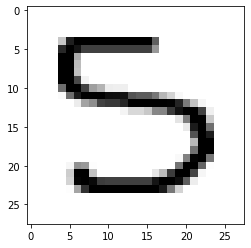

In [5]:
img = ARR_FINAL_ROWS[3][0][0]  #word = row,cols ;returns chars array of that word

plt.imshow(img)
plt.show()

In [6]:
ARR_FINAL_PREDICTION = []
for row in range(len(ARR_FINAL_ROWS)):
    
    ARR_FINAL_PREDICTION_ROWS = []
    for col in range(len(ARR_FINAL_ROWS[row])):
        
        ARR_FINAL_PREDICTION_WORDS = []
        for char in range(len(ARR_FINAL_ROWS[row][col])):
            # ------------------------------------------------
            # STEP 6: CONVERT 28x28 TO FLAT ARRAY
            # ------------------------------------------------
            x_test = []
            
            bw = ARR_FINAL_ROWS[row][col][char].convert('L')
            img_array = np.invert(bw)
            test_img = img_array.ravel()
            x_test.append(test_img)
            
            # ------------------------------------------------
            # STEP 7: LOAD MODEL AND CREATE SESSION
            # ------------------------------------------------
            # Create a graph obj placeholder
            graph = tf.Graph()

            # Creating a sess obj and linking session and the graph
            sess = tf.compat.v1.Session(graph=graph)

            # Loading the Model
            load(sess=sess, tags=[tag_constants.SERVING], export_dir='SavedModel')

            # ------------------------------------------------
            # STEP 8: MAKING PREDICTIONS
            # ------------------------------------------------
            # Return the `Tensor` with the given `name` and index=0 result
            X = graph.get_tensor_by_name('X:0')

            # Get hold of the tensor that will hold the predictions from the graph. Store these under y_pred
            y_pred = graph.get_tensor_by_name('accuracy_calc/prediction:0')

            # fetches = y_pred(the output we are after)
            prediction = sess.run(fetches=y_pred, feed_dict={X: x_test})
            
            # ------------------------------------
            # 9. APPENDING CHARS TO WORDS ARRAY
            # ------------------------------------
            ARR_FINAL_PREDICTION_WORDS.append(prediction)
            
        ARR_FINAL_PREDICTION_ROWS.append(ARR_FINAL_PREDICTION_WORDS)
        
    ARR_FINAL_PREDICTION.append(ARR_FINAL_PREDICTION_ROWS)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from SavedModel/variables/variables
INFO:tensorflow:Restoring parameters from SavedModel/variables/variables
INFO:tensorflow:Restoring parameters from SavedModel/variables/variables
INFO:tensorflow:Restoring parameters from SavedModel/variables/variables
INFO:tensorflow:Restoring parameters from SavedModel/variables/variables
INFO:tensorflow:Restoring parameters from SavedModel/variables/variables
INFO:tensorflow:Restoring parameters from SavedModel/variables/variables
INFO:tensorflow:Restoring parameters from SavedModel/variables/variables
INFO:tensorflow:Restoring parameters from SavedModel/variables/variables
INFO:tensorflow:Restoring parameters from SavedModel/variables/variables
INFO:tensorflow:Resto

In [7]:
len(ARR_FINAL_PREDICTION[0][1])

IndexError: list index out of range

In [ ]:
# ------------------------------------------
# 10. DECODING ALHPABETS AND CONCATENATIING
#     THEM INTO STRING
# -----------------------------------------
result = ''
for row in range(len(ARR_FINAL_PREDICTION)):
    for col in range(len(ARR_FINAL_PREDICTION[row])):
        for char in range(len(ARR_FINAL_PREDICTION[row][col])):
            result = result + ALPHABETS[ARR_FINAL_PREDICTION[row][col][char][0]]
            
        result = result + ' '
        
    result = result + '\n'

In [ ]:
print(result)